In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

## BasicBlock, BottleNeck block

In [2]:
import torch
from torch import Tensor
import torch.nn as nn


class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, noResidual=False):
        super(BasicBlock, self).__init__()
        self.noResidual=noResidual

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
                
    def forward(self, x: Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.noResidual == False:
            x += self.residual(out)
        x = self.relu2(x)
        return x
    
class BottleNeck(nn.Module):
    expansion_factor = 4
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, noResidual=False):
        super(BottleNeck, self).__init__()
        self.noResidual=noResidual

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion_factor)
        
        self.relu3 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
        
    def forward(self, x:Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)

        if self.noResidual == False:
            x += self.residual(out)
        x = self.relu3(x)
        return x

## ResNet Model

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, noResidual=False):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.noResidual=noResidual
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU())
        
        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

        self._init_layer()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, noResidual=self.noResidual))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.dropout(x)
        x = self.fc(x)
        return x

In [4]:
class Model:
    def resnet18(self):
        return ResNet(BasicBlock, [2, 2, 2, 2])

    def resnet50(self):
        return ResNet(BottleNeck, [3, 4, 6, 3])
    
class ModelNoResidual:
    def resnet18(self):
        return ResNet(BasicBlock, [2, 2, 2, 2],noResidual=True)

    def resnet50(self):
        return ResNet(BottleNeck, [3, 4, 6, 3],noResidual=True)

## batch size, epoch size

In [5]:
BATCH_SIZE = 300
EPOCH = 40

## Data Loader

In [6]:

#=================================================
# seed 고정
import random
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#=================================================
# trainloader 생성
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def get_loaders(seed=42, batch_size=256):
    # 시드 고정
    set_seed(seed)

    trainset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform_train,
    )

    testset = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform_test,
    )

    # num_workers=0 이면 set_seed만으로 재현성 확보 쉬움
    trainloader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    testloader = DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    return trainloader, testloader

In [7]:
#print(f'train size: {len(trainset)}')
#print(f'test size: {len(testset)}')
#print(f'train batch len: {len(trainloader)}')
#print(f'test batch len: {len(testloader)}')

## Train

In [8]:
import time
import torch, gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [
    lambda: Model().resnet18(),
    lambda: ModelNoResidual().resnet18(),
    lambda: Model().resnet50(),
    lambda: ModelNoResidual().resnet50()
    ]

resnet_name = ['resnet18', 'resnet18_NoResidual', 'resnet50', 'resnet50_NoResidual']
resnet_train_losses = [[],[],[],[]]
resnet_val_accuracy = [[],[],[],[]]

for i_model in range(4):
    current_time = time.time()

    model=models[i_model]().to(device)
    print(f'Start:{resnet_name[i_model]}============================')
    
    SEED = 42
    trainloader, testloader = get_loaders(seed=SEED, batch_size=BATCH_SIZE)
    #================================
    for param in model.parameters():
        param.requires_grad = True
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    for epoch in range(EPOCH):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # if i % 100 == 99:
            #     print(f"[Epoch:{epoch + 1}, Batch:{i + 1:5d}] loss: {running_loss / 100:.3f}")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        resnet_train_losses[i_model].append(train_loss)


        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        resnet_val_accuracy[i_model].append(val_acc)

        print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}% | Validation Accuracy: {val_acc:.2f}%")

        if train_acc > 90:
            break

    print("Finished Training")
    print("Time Elapsed:",time.time() - current_time)

    #================================
    del model, inputs, labels, loss, outputs, predicted # 1) 더 이상 안 쓰는 텐서/모델 참조 지우기
    gc.collect()    # 2) 파이썬 가비지 컬렉터 실행
    if torch.cuda.is_available():
        torch.cuda.empty_cache()    # 3) PyTorch CUDA 캐시 비우기
        torch.cuda.reset_peak_memory_stats()    # (선택) 통계 리셋


Start:resnet18============================
Epoch 1: Train Accuracy: 22.84% | Validation Accuracy: 32.27%
Epoch 2: Train Accuracy: 34.26% | Validation Accuracy: 39.06%
Epoch 3: Train Accuracy: 39.67% | Validation Accuracy: 42.54%
Epoch 4: Train Accuracy: 43.42% | Validation Accuracy: 46.01%
Epoch 5: Train Accuracy: 46.31% | Validation Accuracy: 48.31%
Epoch 6: Train Accuracy: 48.88% | Validation Accuracy: 48.93%
Epoch 7: Train Accuracy: 51.43% | Validation Accuracy: 52.36%
Epoch 8: Train Accuracy: 53.24% | Validation Accuracy: 54.82%
Epoch 9: Train Accuracy: 55.23% | Validation Accuracy: 55.54%
Epoch 10: Train Accuracy: 56.94% | Validation Accuracy: 57.98%
Epoch 11: Train Accuracy: 58.67% | Validation Accuracy: 58.98%
Epoch 12: Train Accuracy: 60.38% | Validation Accuracy: 59.99%
Epoch 13: Train Accuracy: 61.54% | Validation Accuracy: 61.93%
Epoch 14: Train Accuracy: 63.21% | Validation Accuracy: 63.36%
Epoch 15: Train Accuracy: 64.32% | Validation Accuracy: 63.52%
Epoch 16: Train Accur

## Learing curve 및 데이터 분석

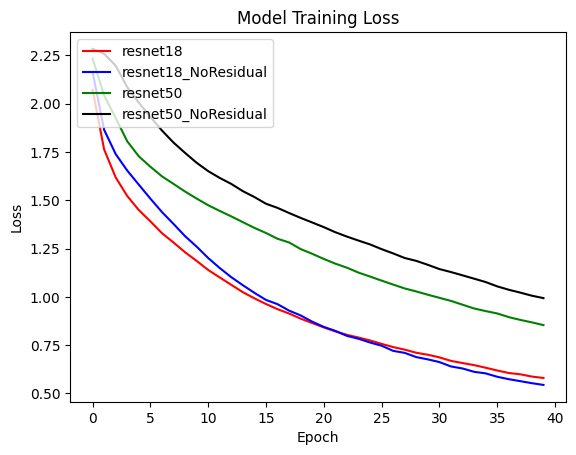

In [9]:
# learning curve- 훈련 손실(training loss) 비교
import matplotlib.pyplot as plt
resnet_name = ['resnet18', 'resnet18_NoResidual', 'resnet50', 'resnet50_NoResidual']
color=['r','b','g','k']

for i in range(4):
    plt.plot(resnet_train_losses[i], color[i], label=resnet_name[i])

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

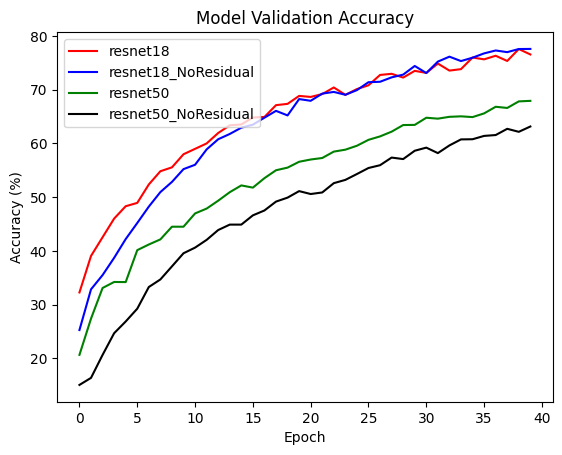

In [10]:
# learning curve- 검증 정확도(validation accuracy)를 비교
import matplotlib.pyplot as plt
resnet_name = ['resnet18', 'resnet18_NoResidual', 'resnet50', 'resnet50_NoResidual']
color=['r','b','g','k']

for i in range(4):
    plt.plot(resnet_val_accuracy[i], color[i], label=resnet_name[i])

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [12]:
resnet_name = ['resnet18', 'resnet18_NoResidual', 'resnet50', 'resnet50_NoResidual']
for i in range(4):
    print(f'[{resnet_name[i]}]  train_loss:{resnet_train_losses[i][-1]}, val_accuracy:{resnet_val_accuracy[i][-1]}')

    

[resnet18]  train_loss:0.5795146867543638, val_accuracy:76.54
[resnet18_NoResidual]  train_loss:0.5434917654106003, val_accuracy:77.57
[resnet50]  train_loss:0.8533112702969305, val_accuracy:67.91
[resnet50_NoResidual]  train_loss:0.9930791908395504, val_accuracy:63.14


## 고찰 및 후기

residual connection 의 효과를 검증하기 위해 아래와 같이 실험을 진행했다.<br>
DATA: CIFAR10, <br>
Model: ResNet18, ResNet50<br>
(각각 Residual connecton이 있는 모델과 없는 모델, 총 4개)<br>

1. CIFAR10 에 맞게 ResNet 일부 layer수정<br>
        '''<br>
        self.conv1 = nn.Sequential(<br>
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),<br>
            nn.BatchNorm2d(num_features=64),<br>
            nn.ReLU(),<br>
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))<br>
        '''<br>
        self.conv1 = nn.Sequential(<br>
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),<br>
            nn.BatchNorm2d(num_features=64),<br>
            nn.ReLU())<br>

2. DATA를 그대로 사용시 과적합이 일어나므로 data augmentation 수행
- RandomCrop(32, padding=4), RandomHorizontalFlip()

3. 동등한 조건에서 실험하기 위해 parameter 통제
- DATA Normalize 값 동일
- Dropout 배제
- random seed 적용으로 4개 모델에 동일한 data augmention 결과 전달

(결과)
1. 짧은 레이어 깊이 모델
- Residual 유무에 따른 효과 없음. 거의 같은 Loss, Accuracy로 수렴

2. 긴 레이어 깊이 모델
- Residual 유무에 따른 효과 있음. Residual이 있는 모델이 없는 모델보다 성능이 우수
- 짧은 레이어 보다 성능이 개선됨은 실험 시간 부족으로 확인하지 못함
    - 예상
    - Residual이 없는 모델은 짧은 레이어와 동등한 성능 혹은 약간 더 나은 성능
    - Residual이 있는 모델은 가능 나은 성능

(후기)
- Residual connection 효과 확인
- 학습 시간에 대해 어느정도 예측하는 것이 필요하다는 것을 느낌
- 시간 부족으로 짧은 레이어와 긴 레이어의 비교가 부족했음은 아쉬움